In [1]:
import datetime as dt
import os, sys
import netCDF4 as nc
import matplotlib as mpl
import numpy as np
import numpy.ma as ma
from scipy.spatial import distance
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib import cm
import matplotlib.colors as mpl_colors
from matplotlib import rc
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cmocean



from salishsea_tools import geo_tools, viz_tools

get_ipython().magic('matplotlib inline')

In [2]:




filesdir = "/ocean/gsgarbi/selected_days/"

dirs = os.listdir(filesdir)


season_files = ("wfiles", "spfiles", "sufiles", "ffiles")
season_keys = ['winter', 'spring', 'summer', 'fall']
abv = {"winter": "FMA", "spring": "MJJ", "summer": "ASO", "fall": "NDJ" }

Iona = (-123.30898284912109, 49.187351226806641)
S15 = (-123.3114, 49.130412)
S16 = (-123.317415, 49.1214)
xl=(-126.2,-122.2)
yl=(47.1,51)

In [3]:
def plot(points, title = 'title', picname = "noname", b=0):
    
    

    cmap.set_bad('burlywood')


    plt.clf()
    start = dt.datetime.now()
    print ("start: ", start)

    mesh = nc.Dataset("/ocean/gsgarbi/mesh_mask_downbyone2.nc")
    tmask=np.copy(mesh.variables['tmask'])
    mesh.close()
    fb=nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/bathy_downonegrid2.nc')
    nav_lon=np.copy(fb.variables['nav_lon'])
    nav_lat=np.copy(fb.variables['nav_lat'])
    fb.close()
    
    lonlim=[np.min(nav_lon),np.max(nav_lon)]
    latlim=[np.min(nav_lat),np.max(nav_lat)]


    griddata=0.0*tmask[0,0,:,:]
    griddata.shape


    griddata, iedges, jedges = np.histogram2d(points[:,1],
                                              points[:,2],
                                              bins=[100,200],
                                              range=[lonlim,
                                                     latlim
                                                    ]
                                             )


    Jedges,Iedges=np.meshgrid(jedges,iedges)
    

    fig, axs = plt.subplots(1,1,figsize=(6,4))
    mesh0 = axs.pcolormesh(Iedges,Jedges,griddata,cmap=cmap) #histogram
    mesh0.set_clim(vmin = 0, vmax = vmax)
    axs.set_xlim(xl)
    axs.set_ylim(yl)
    pos=axs.get_position()
    pos2=(pos.bounds[0],pos.bounds[1],pos.bounds[2]-.05,pos.bounds[3])
    axs.set_position(pos2)
    axs2 = plt.axes(pos2)
    viz_tools.set_aspect(axs,coords='map')
    mesh1=axs2.pcolormesh(nav_lon,
                          nav_lat,
                          np.ma.masked_where(tmask[0,0,:,:]==1,
                          tmask[0,0,:,:]),
                          cmap='YlOrRd') #Background
    axs2.set_xlim(xl)
    axs2.set_ylim(yl)
    axs2.patch.set_alpha(0)
    viz_tools.set_aspect(axs2,coords='map')
    axsCB=plt.axes((pos2[0]+pos2[3] - 0.145,pos2[1],.02,pos2[3]))
    cbar = fig.colorbar(mesh0,cax=axsCB)
    cbar.set_label ("Counts")
    

    


    axs2.annotate(
            "   IONA",
            xy=(Iona[0], Iona[1]), xytext=(20, 15),
            textcoords='offset points', ha='left', va='bottom', color = 'white',
            arrowprops=dict(arrowstyle="wedge,tail_width=1.",
                                      fc=(1,1,1), ec=(1., .5, .5),
                                      patchA=None,
                                      patchB=Ellipse((2, -1), 0.5, 0.5),
                                      relpos=(0.2, 0.8),
                                      connectionstyle="arc3,rad=-0.1")
                )

    fb=nc.Dataset('/ocean/gsgarbi/revised_notebooks/ncfiles/bathymetry_201702.nc')

    B = np.copy(fb.variables ['Bathymetry'])
    LON = np.copy(fb.variables ['nav_lon'])
    LAT = np.copy(fb.variables ['nav_lat'])
    fb.close()
   
    axs2.contour(LON,LAT,B,levels=[50,], colors = ['w',], linewidths = [0.4,])
        
    xc = np.mean(points[:,1])
    yc = np.mean(points[:,2])
    xs = np.std(points[:,1])
    ys = np.std(points[:,2])
    
    axs2.plot(xc,yc,"kx", ms = 10)
    
    axs.set_title( title, fontsize = 10 )
                                                        
    
    
    plt.savefig(picname, transparent = True, dpi = 400)
    
    for item in [fig, axs, axs2, axsCB]:
        item.patch.set_visible(True)

    


In [4]:
wfiles = [i for i in dirs if i[:6] in ("201602", "201603", "201604")]
spfiles = [i for i in dirs if i[:6] in ("201605", "201606", "201607")]
sufiles = [i for i in dirs if i[:6] in ("201608", "201609", "201610")]
ffiles = [i for i in dirs if i[:6] in ("201611", "201612", "201701")]

files = {'winter': wfiles, 'spring': spfiles, 'summer': sufiles, 'fall': ffiles}
seasons = {}

In [5]:
def select_files (nday):

    seasons = {}

    for season in season_keys:
        seasons [season] = []
        for file in files[season]:
            if "{}d.npy".format (nday) == file [18:]:
                month = np.load(open(filesdir + file, 'rb'))
                seasons[season].append( month )

        seasons[season] = np.array([i for seasons[season] 
                                            in seasons[season] for 
                                            i in seasons[season]])
        
    return seasons

In [6]:
def get_b (b):
    B50 = []
    fb=nc.Dataset('/ocean/gsgarbi/revised_notebooks/ncfiles/bathymetry_201702.nc')

    B = np.copy(fb.variables ['Bathymetry'])
    LON = np.copy(fb.variables ['nav_lon'])
    LAT = np.copy(fb.variables ['nav_lat'])
    fb.close()
    m = np.shape(B)[0] - 1
    n = np.shape(B)[1] - 1
    x = []
    y = []
    for i in range (m):
        for j in range (n):
            if abs(B[i,j] - b) < 1:
                x.append(LON[i,j]) 
                y.append (LAT[i,j])
    return x,y

start:  2017-07-20 15:49:13.743146


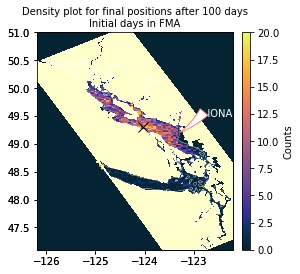

start:  2017-07-20 15:49:15.119678


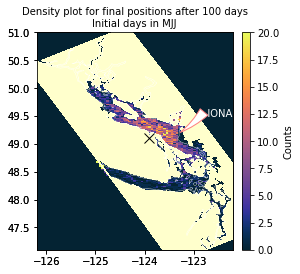

start:  2017-07-20 15:49:16.430159


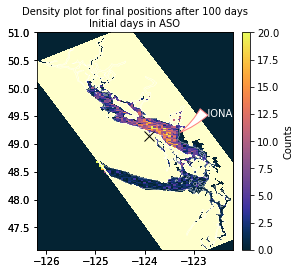

start:  2017-07-20 15:49:17.722283


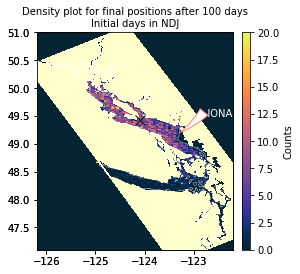

In [7]:
nday = 100
vmax = 20

cmap = cmocean.cm.thermal

change = 1

for season in season_keys:

    
    if change < 0:
        
        print ('changed')
    
        cmap = cmocean.cm.solar
    else:
        cmap = cmocean.cm.thermal
    
    seasons = select_files(nday)

    points = seasons[season]

    
    title = (
        "Density plot for final positions after {} days\nInitial days in {}".format(nday, abv[season])
    )
    
    
    
    picname = "/ocean/gsgarbi/MEOPAR/private-docs/reports/IonaProject/ionafigs/{}d_{}.png".format(nday, abv[season])

    plot (points, title, picname)
    
#     change *= -1
    

    

    
    plt.show()

/ocean/gsgarbi/MEOPAR/private-docs/reports/IonaProject/ionafigs/50d_FMA.png
start:  2017-07-20 15:49:19.065625


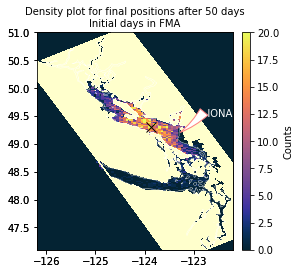

/ocean/gsgarbi/MEOPAR/private-docs/reports/IonaProject/ionafigs/50d_MJJ.png
start:  2017-07-20 15:49:20.365567


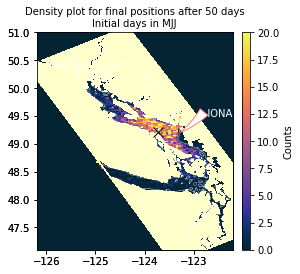

/ocean/gsgarbi/MEOPAR/private-docs/reports/IonaProject/ionafigs/50d_ASO.png
start:  2017-07-20 15:49:21.739250


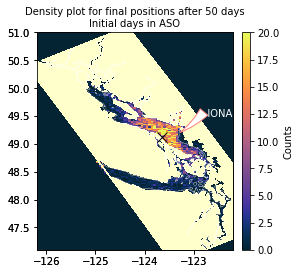

/ocean/gsgarbi/MEOPAR/private-docs/reports/IonaProject/ionafigs/50d_NDJ.png
start:  2017-07-20 15:49:23.109566


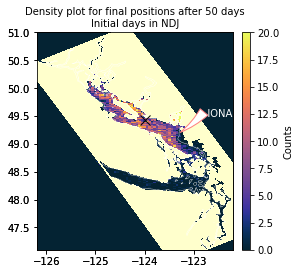

In [8]:
nday = 50
vmax = 20

for season in season_keys:
    
    seasons = select_files(nday)

    points = seasons[season]

    
    title = (
        "Density plot for final positions after {} days\nInitial days in {}".format(nday, abv[season])
    )

    picname = "/ocean/gsgarbi/MEOPAR/private-docs/reports/IonaProject/ionafigs/{}d_{}.png".format(nday, abv[season])
    
    print (picname)

    plot (points, title, picname)
    
    plt.plot
    
    plt.show()
